# Efficient Frontier using Convex Optimization with cvxpy

In [2]:
import cvxpy as cp
import numpy as np
import scipy.optimize as sco
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [4]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [5]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['META', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [6]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  4 of 4 completed
Downloaded 250 rows of data.


<AxesSubplot:title={'center':'Stock prices of the considered assets'}, xlabel='Date'>

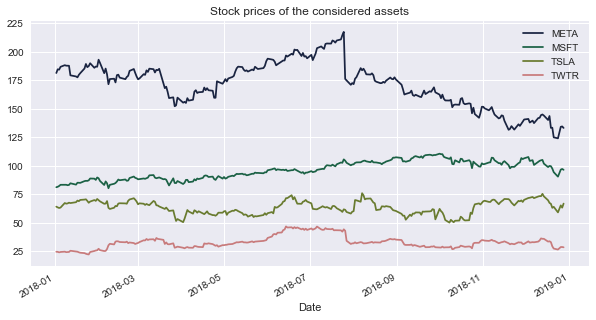

In [7]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets', figsize=(10,5))

In [8]:
# Calculate annualized average returns and the corresponding standard deviation

returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [9]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [10]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

c:\Users\gabrielanatalia\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\expressions\expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


In [11]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

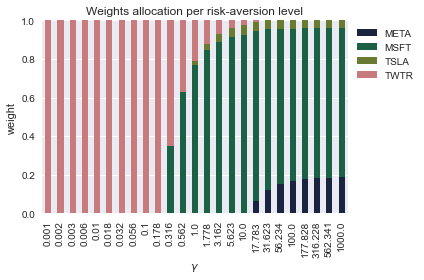

In [12]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=RISKY_ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

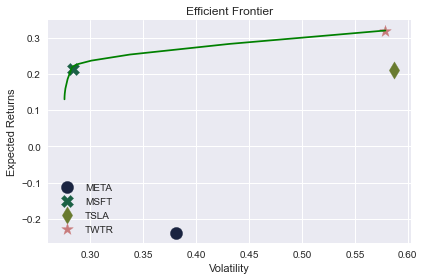

In [13]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=RISKY_ASSETS[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()
plt.show()

In [14]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [15]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [16]:
vols_range = [x['fun'] for x in efficient_portfolios]

We can also plot the two Efficient Frontiers for comparison—the one calculated by
minimizing the volatility per expected level of return, and the other one using the convex
optimization and maximizing the risk-adjusted return.

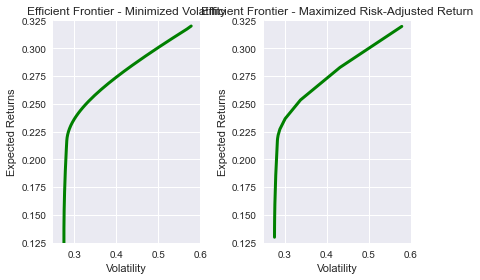

In [17]:
x_lim = [0.25, 0.6]
y_lim = [0.125, 0.325]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Efficient Frontier - Minimized Volatility',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Efficient Frontier - Maximized Risk-Adjusted Return',
          xlabel='Volatility', 
          ylabel='Expected Returns',
          xlim=x_lim, 
          ylim=y_lim)

plt.tight_layout()
plt.show()

Another interesting concept we can incorporate into the analysis is the maximum allowable leverage. We replace the non-negativity constraints on the weights with a max leverage
constraint, using the norm of a vector.

In [18]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, 
                                   [cp.sum(weights) == 1, 
                                    cp.norm(weights, 1) <= max_leverage])

In the following code block, we modify the code, this time to include two loops—one over potential values of the risk-aversion parameter, and the other one indicating the maximum
allowable leverage. Max leverage equal to 1 (meaning no leverage) results in a case similar to the previous optimization problem (only this time, there is no non-negativity constraint).

In [19]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve()
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value
        

We plot the Efficient Frontiers for different maximum leverages. We can clearly see that higher leverage increases returns and, at the same time,
allows for greater volatility

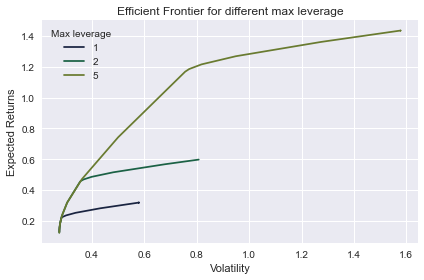

In [20]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l_ef[:, leverage_index], 
             portf_rtn_l_ef[:, leverage_index], 
             label=f'{leverage}')

ax.set(title='Efficient Frontier for different max leverage',
       xlabel='Volatility', 
       ylabel='Expected Returns')
ax.legend(title='Max leverage')

plt.tight_layout()
plt.show()

Lastly, we also recreate the plot showing weight allocation per varying risk-aversion levels.
With a maximum leverage of 1, there is no short-selling.

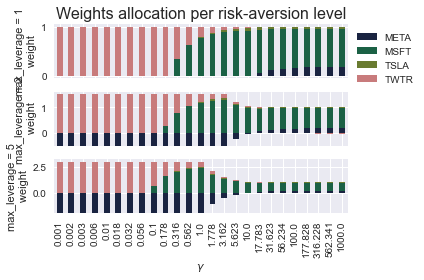

In [21]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=RISKY_ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar', 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}' 
                             '\n weight'))

    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)

plt.tight_layout()
plt.show()